# Tertiary Contacts

In [22]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn2_circles
from rna_motif_library.plotting import publication_style_ax

In [23]:
df = pd.read_json("../data/summaries/tertiary_contacts/unique_tertiary_contacts.json")
df_lora = pd.read_json("../lora_contacts_processed.json")
df_lora = df_lora[df_lora["in_our_db"] == False]

In [24]:
# Remove rows where either mtype_1 or mtype_2 is "UNKNOWN"
df = df[(df["motif_1_type"] != "UNKNOWN") & (df["motif_2_type"] != "UNKNOWN")]

## comparision with lora

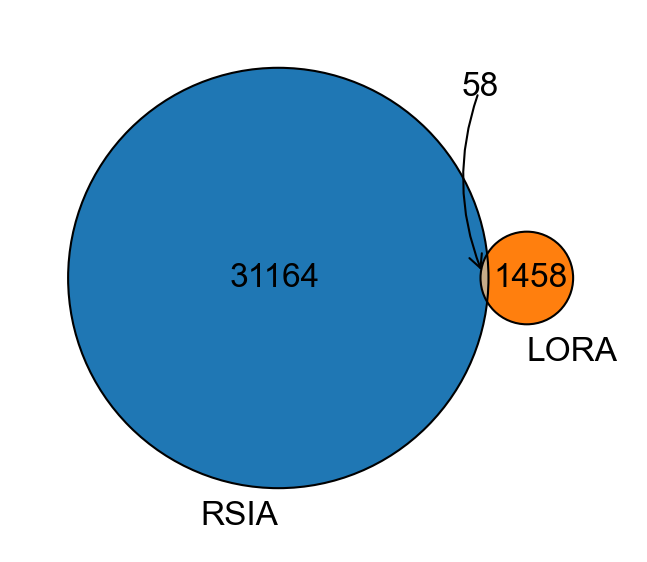

In [25]:
fig, ax = plt.subplots(figsize=(2.5, 2.5), dpi=300)

# Create the Venn diagram with seaborn default colors
colors = sns.color_palette()[:2]  # Get first two colors from default palette
v = venn2(
    subsets=(len(df), 1458, 58),
    set_labels=("RSIA", "LORA"),
    set_colors=colors,
    alpha=1.0,
)
c = venn2_circles(subsets=(len(df), 1458, 58), linestyle="solid", lw=0.5)

# Get the center of the overlap region
overlap_center = v.get_label_by_id("11").get_position()

# Calculate arrow start position (slightly offset from center)
arrow_start = (0.50, 0.50)

# Add arrow pointing to overlap
ax.annotate(
    "",
    xy=overlap_center,  # Point to overlap
    xytext=arrow_start,  # Start from center of plot
    arrowprops=dict(
        arrowstyle="->", color="black", lw=0.5, connectionstyle="arc3,rad=0.2"
    ),
)  # Curved arrow

# Add text label at the base of the arrow
ax.text(arrow_start[0], arrow_start[1], "58", ha="center", va="center", fontsize=8)

# Hide the original overlap label
v.get_label_by_id("11").set_text("")

publication_style_ax(ax)

In [26]:
df_lora["reason"] = ""
df_lora.loc[
    (df_lora["more_than_2_motifs"] == True) & (df_lora["reason"] == ""), "reason"
] = "More than 2 motifs"
df_lora.loc[
    (df_lora["connected_strands"] == False) & (df_lora["reason"] == ""), "reason"
] = "Shared basepair"
df_lora.loc[(df_lora["hbond_score"] < 3) & (df_lora["reason"] == ""), "reason"] = (
    "Transient Interaction"
)
df_lora.loc[df_lora["reason"] == "", "reason"] = "Other"

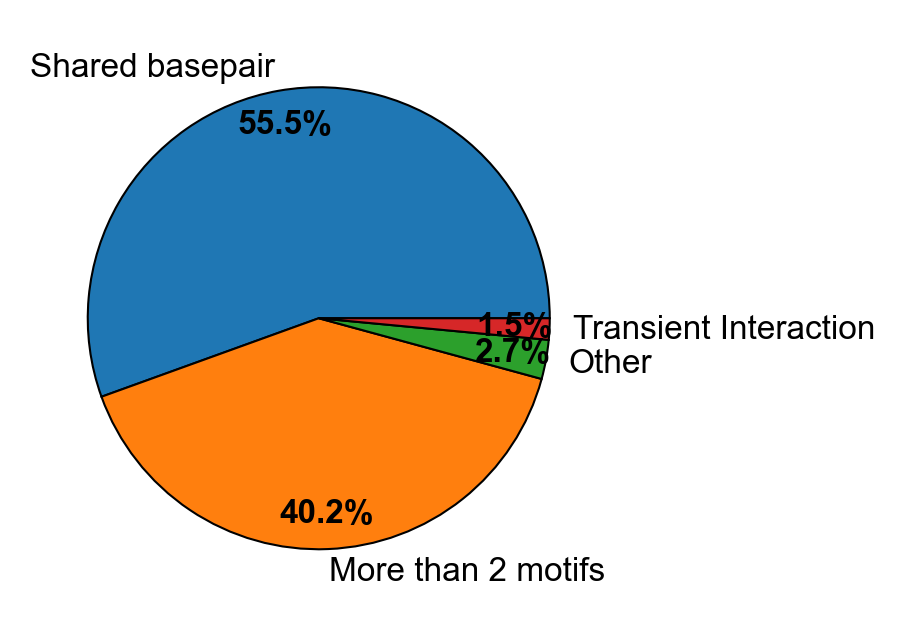

In [27]:
# Get value counts and sort in descending order
reason_counts = df_lora["reason"].value_counts()

# Filter out values less than 0.2%
total = reason_counts.sum()

# Create figure and axis
fig, ax = plt.subplots(figsize=(2.5, 2.5), dpi=300)

# Create pie chart with different colors
colors = sns.color_palette()[: len(reason_counts)]  # Use default color palette
wedges, texts, autotexts = ax.pie(
    reason_counts.values,
    labels=reason_counts.index,
    colors=colors,
    autopct="%1.1f%%",
    pctdistance=0.85,
    wedgeprops=dict(edgecolor="black", linewidth=0.5),
)

# Customize plot
plt.setp(autotexts, size=6, weight="bold", fontname="Arial")
plt.setp(texts, size=6, fontname="Arial")

publication_style_ax(ax)

## find examples

In [28]:
df.columns

Index(['motif_1_id', 'motif_2_id', 'motif_1_type', 'motif_2_type',
       'motif_1_size', 'motif_2_size', 'm_sequence_1', 'm_sequence_2',
       'motif_1_res', 'motif_2_res', 'num_hbonds', 'hbond_score',
       'num_base_base_hbonds', 'num_base_sugar_hbonds',
       'num_base_phosphate_hbonds', 'num_phosphate_sugar_hbonds',
       'num_phosphate_phosphate_hbonds', 'pdb_id', 'is_motif_1_unique',
       'is_motif_2_unique'],
      dtype='object')

In [29]:
df = df.sort_values("num_hbonds", ascending=False)

In [ ]:
df_sub = df.query("motif_1_type == 'SSTRAND' and motif_2_type == 'SSTRAND'")
# Get value counts of pdb_id and find the one with most entries
pdb_counts = df_sub["pdb_id"].value_counts()
most_common_pdb = pdb_counts.index[0]
print(f"PDB ID with most entries: {most_common_pdb} ({pdb_counts.iloc[0]} entries)")
print("\nAll entries for this PDB ID:")
df_sub[df_sub["pdb_id"] == most_common_pdb]

PDB ID with most entries: 7ASO (68 entries)

All entries for this PDB ID:


,motif_1_id,motif_2_id,motif_1_type,motif_2_type,motif_1_size,motif_2_size,m_sequence_1,m_sequence_2,motif_1_res,motif_2_res,num_hbonds,hbond_score,num_base_base_hbonds,num_base_sugar_hbonds,num_base_phosphate_hbonds,num_phosphate_sugar_hbonds,num_phosphate_phosphate_hbonds,pdb_id,is_motif_1_unique,is_motif_2_unique
14644,SSTRAND-66-GCACAAGCGGUGGAGCAUGUGGUUUAAUUCGAAGC...,SSTRAND-67-UUAUGAUUUGGGCUACACACGUGCUACAAUGGACA...,SSTRAND,SSTRAND,66,67,GCACAAGCGGUGGAGCAUGUGGUUUAAUUCGAAGCAACGCGAAGAA...,UUAUGAUUUGGGCUACACACGUGCUACAAUGGACAAUACAAAGGGC...,"[X-A-959-, X-C-989-, X-A-998-, X-C-994-, X-A-9...","[X-G-1244-, X-G-1233-, X-U-1228-, X-U-1230-, X...",40,28.465260,24,5,6,2,0,7ASO,1,1
14633,SSTRAND-30-AAUCCCAUAAAGUUGUUCUCAGUUCGGAUU-7ASO-1,SSTRAND-67-UUAUGAUUUGGGCUACACACGUGCUACAAUGGACA...,SSTRAND,SSTRAND,30,67,AAUCCCAUAAAGUUGUUCUCAGUUCGGAUU,UUAUGAUUUGGGCUACACACGUGCUACAAUGGACAAUACAAAGGGC...,"[X-U-1302-, X-C-1294-, X-U-1306-, X-A-1299-, X...","[X-A-1259-, X-G-1271-, X-A-1254-, X-C-1260-, X...",30,21.661272,17,5,3,1,0,7ASO,1,1
14605,SSTRAND-18-GUUUGUAACACCCGAAGC-7ASO-1,SSTRAND-18-UCGAAGGUGGGACAAAUG-7ASO-1,SSTRAND,SSTRAND,18,18,GUUUGUAACACCCGAAGC,UCGAAGGUGGGACAAAUG,"[X-G-1446-, X-C-1440-, X-C-1438-, X-G-1430-, X...","[X-C-1478-, X-G-1483-, X-G-1487-, X-G-1485-, X...",29,22.750721,24,2,2,0,0,7ASO,1,1
14611,SSTRAND-22-GAGAUAUGGAGGAACACCAGUG-7ASO-1,SSTRAND-34-AAAGUGGAAUUCCAUGUGUAGCGGUGAAAUGCGC-...,SSTRAND,SSTRAND,22,34,GAGAUAUGGAGGAACACCAGUG,AAAGUGGAAUUCCAUGUGUAGCGGUGAAAUGCGC,"[X-A-724-, X-G-713-, X-A-714-, X-G-718-, X-A-7...","[X-G-682-, X-C-697-, X-G-693-, X-U-690-, X-C-7...",28,21.915024,17,5,3,1,0,7ASO,1,1
14601,SSTRAND-18-GAAAGCGUGGGGAUCAAA-7ASO-1,SSTRAND-29-GUAGUCCACGCCGUAAACGAUGAGUGCUA-7ASO-1,SSTRAND,SSTRAND,18,29,GAAAGCGUGGGGAUCAAA,GUAGUCCACGCCGUAAACGAUGAGUGCUA,"[X-G-782-, X-U-780-, X-A-776-, X-G-777-, X-G-7...","[X-C-813-, X-C-816-, X-G-820-, X-C-819-, X-G-8...",26,17.916356,16,7,3,0,0,7ASO,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14575,SSTRAND-10-AGUGAAAGAC-7ASO-1,SSTRAND-28-UAACCUACCUAUAAGACUGGGAUAACUU-7ASO-1,SSTRAND,SSTRAND,10,28,AGUGAAAGAC,UAACCUACCUAUAAGACUGGGAUAACUU,"[X-A-210-, X-G-209-]","[X-G-142-, X-A-141-]",3,2.051601,1,2,0,0,0,7ASO,1,1
14629,SSTRAND-29-GUAGUCCACGCCGUAAACGAUGAGUGCUA-7ASO-1,SSTRAND-3-GCA-7ASO-1,SSTRAND,SSTRAND,29,3,GUAGUCCACGCCGUAAACGAUGAGUGCUA,GCA,[X-A-836-],"[X-G-868-, X-C-869-]",3,2.087944,2,1,0,0,0,7ASO,1,1
14636,SSTRAND-33-UUGGAUUGCACGUCUAAGCAGUAAGGCUGAGUA-7...,SSTRAND-8-AGGAUAGG-7ASO-1,SSTRAND,SSTRAND,33,8,UUGGAUUGCACGUCUAAGCAGUAAGGCUGAGUA,AGGAUAGG,"[Y-A-1520-, Y-A-1521-]","[Y-G-1480-, Y-G-1479-]",3,2.436644,0,2,0,0,0,7ASO,1,1
14638,SSTRAND-4-CGUA-7ASO-1,SSTRAND-8-UAUUAAGG-7ASO-1,SSTRAND,SSTRAND,4,8,CGUA,UAUUAAGG,"[Y-A-2656-, Y-U-2655-]","[Y-U-9-, Y-A-10-]",3,2.074884,2,0,1,0,0,7ASO,0,1


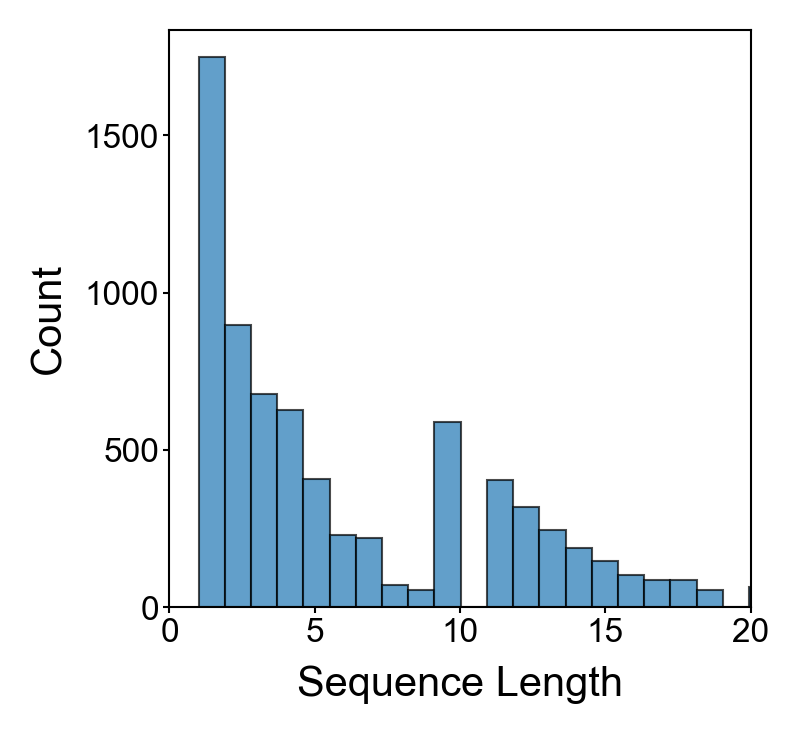

In [44]:
# Create figure and axis
fig, ax = plt.subplots(figsize=(2.5, 2.5), dpi=300)

# Get SSTRAND entries
df_strand = df.query("motif_1_type == 'SSTRAND' and motif_2_type == 'SSTRAND'")

# Create histogram of sequence lengths
ax.hist(
    df_strand["m_sequence_1"].str.len(),
    bins=500,
    alpha=0.7,
    edgecolor="black",
    linewidth=0.5,
)

# Customize plot
ax.set_xlim(0, 20)
ax.set_xlabel("Sequence Length")
ax.set_ylabel("Count")
publication_style_ax(ax)

In [45]:
df.query("motif_1_type == 'SSTRAND' and motif_2_type == 'SSTRAND'").query(
    "m_sequence_1.str.len() == 1 or m_sequence_2.str.len() == 1"
)

,motif_1_id,motif_2_id,motif_1_type,motif_2_type,motif_1_size,motif_2_size,m_sequence_1,m_sequence_2,motif_1_res,motif_2_res,num_hbonds,hbond_score,num_base_base_hbonds,num_base_sugar_hbonds,num_base_phosphate_hbonds,num_phosphate_sugar_hbonds,num_phosphate_phosphate_hbonds,pdb_id,is_motif_1_unique,is_motif_2_unique
15191,SSTRAND-1-G-8EUY-3,SSTRAND-4-GAAA-8EUY-1,SSTRAND,SSTRAND,1,4,G,GAAA,[1-G-1331-],"[1-A-1235-, 1-A-1234-, 1-A-1233-]",8,5.901935,4,2,0,1,0,8EUY,1,0
25929,SSTRAND-1-G-7YG8-2,SSTRAND-5-UCACA-7YG8-1,SSTRAND,SSTRAND,1,5,G,UCACA,[N-G-312-],"[N-C-262-, N-A-263-]",7,5.909525,5,2,0,0,0,7YG8,1,0
25928,SSTRAND-1-G-7YGC-2,SSTRAND-5-UCACA-7YGC-1,SSTRAND,SSTRAND,1,5,G,UCACA,[N-G-312-],"[N-C-262-, N-A-263-]",7,5.898889,5,2,0,0,0,7YGC,1,0
21928,SSTRAND-1-G-7YGD-2,SSTRAND-5-UCACA-7YGD-1,SSTRAND,SSTRAND,1,5,G,UCACA,[N-G-312-],"[N-C-262-, N-A-263-]",7,5.945360,5,2,0,0,0,7YGD,1,0
23766,SSTRAND-1-G-8I9R-2,SSTRAND-4-CAAA-8I9R-1,SSTRAND,SSTRAND,1,4,G,CAAA,[C1-G-1282-],"[C1-A-1184-, C1-A-1185-]",7,5.224982,5,1,0,1,0,8I9R,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4940,SSTRAND-1-U-8UQL-2,SSTRAND-9-UGCACGAAU-8UQL-1,SSTRAND,SSTRAND,1,9,U,UGCACGAAU,[a-U-1834-],[a-A-1970-],3,2.391987,2,0,0,1,0,8UQL,1,0
4939,SSTRAND-1-C-8UQL-3,SSTRAND-7-UGCUGCA-8UQL-1,SSTRAND,SSTRAND,1,7,C,UGCUGCA,[D-C-1208-],[D-G-1050-],3,2.641865,3,0,0,0,0,8UQL,1,0
4938,SSTRAND-1-A-8UQL-4,SSTRAND-4-ACUC-8UQL-1,SSTRAND,SSTRAND,1,4,A,ACUC,[a-A-2070-],"[a-U-2441-, a-C-2442-]",3,2.589450,3,0,0,0,0,8UQL,1,0
4933,SSTRAND-1-A-7P3K-1,SSTRAND-10-GGAAUUACUG-7P3K-1,SSTRAND,SSTRAND,1,10,A,GGAAUUACUG,[A-A-26-],[A-G-558-],3,2.801860,2,1,0,0,0,7P3K,1,0


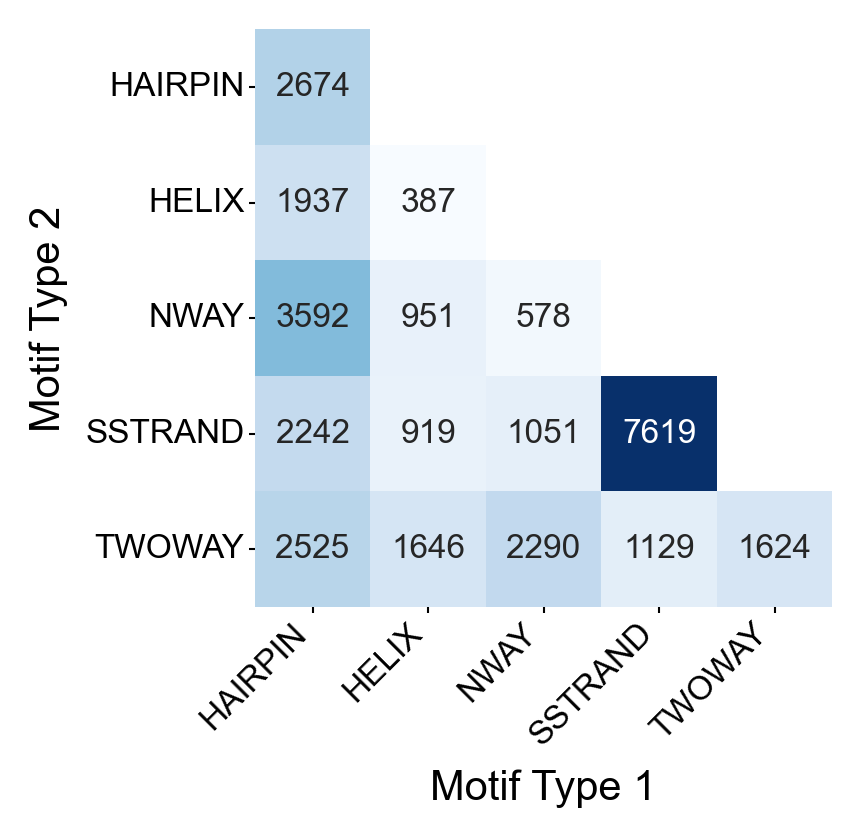

In [54]:
# Create pivot table of counts
pivot = pd.crosstab(df["motif_2_type"], df["motif_1_type"])

# Create heatmap
plt.figure(figsize=(2.5, 2.5), dpi=300)
ax = sns.heatmap(
    pivot,
    annot=True,
    fmt="d",
    cmap="Blues",
    square=True,
    linecolor="black",
    cbar=False,
    mask=pivot == 0,  # Hide cells with value 0
)

# Customize plot
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.xlabel("Motif Type 1")
plt.ylabel("Motif Type 2")
publication_style_ax(ax)